In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import generate_mocks as gm
from dipole import get_dipole, cmb_dipole, measure_overdensity_dipole_Lambda
from qso_sample import QSOSample
import ellisbaldwin

In [3]:
# results dir
RESULTDIR = '/scratch/aew492/lss-dipoles_results/results'

### load recovered dipole in data

In [6]:
dir_results_data = os.path.join(RESULTDIR, 'results_data')
case_dict_data = {
    "catalog_name": 'catwise',
    "selfunc_mode": 'catwise_zodi', #this also multiplies in the mask
    "tag": f"_case-catwise_zodi"
}
fn_comps_data = os.path.join(dir_results_data, f"dipole_comps_Lambdas_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
result_dict = np.load(fn_comps_data, allow_pickle=True).item()
dipole_comps_data = result_dict['dipole_comps']
Lambdas_data = result_dict['Lambdas']

In [7]:
# compute the norm of the dipole components for the actual data
dipole_amps_data = np.linalg.norm(dipole_comps_data, axis=1)

### load recovered dipoles from mocks

In [8]:
# case dictionary
case_dicts_mock = gm.case_set(set_name='ideal_catwise')
# 'ideal_catwise' is just a single case
case_dict_mock = case_dicts_mock[0]

In [9]:
dir_results_mocks = os.path.join(RESULTDIR, 'results_mocks')

pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
print(f"looking for {pattern}...")
fn_comps_mock = glob.glob(pattern)
n_trials = len(fn_comps_mock)
print(f"found {n_trials} files with this pattern")

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/dipole_comps_lambdas*_case-zeros-binary-0.0074-72.420*.npy...
found 1000 files with this pattern


In [10]:
# gather the recovered components
dipole_comps_mocks = []
Lambdas_mocks = []
# not necessary in order, careful!
for i in range(n_trials):
    result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
    dipole_comps_mock = result_dict['dipole_comps']
    dipole_comps_mocks.append(dipole_comps_mock)
    Lambdas_mocks.append(result_dict['Lambdas'])
dipole_comps_mocks = np.array(dipole_comps_mocks)
Lambdas_mocks = np.array(Lambdas_mocks)

In [11]:
# get the amplitudes and directions of the recovered dipole components
dipole_amps_mocks = []
dipole_dirs_mocks = []
for i in range(n_trials):
    dipole_amps_ = []
    dipole_dirs_ = []
    for j in range(len(Lambdas_mocks[0])):
        dipole_amp, dipole_dir = get_dipole(dipole_comps_mocks[i,j])
        dipole_amps_.append(dipole_amp)
        dipole_dirs_.append(dipole_dir)
    dipole_amps_mocks.append(dipole_amps_)
    dipole_dirs_mocks.append(dipole_dirs_)
dipole_amps_mocks = np.array(dipole_amps_mocks)

### plot recovered dipoles

#### amplitudes

In [12]:
# pick a few Lambdas
Lambdas = np.logspace(-3, -1, 5)
iLambdas = np.array([
    np.argmin(np.abs(Lambdas_mocks[0]-Lambda)) for Lambda in Lambdas
])
norm = mpl.colors.LogNorm(vmin=min(Lambdas), vmax=max(Lambdas))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

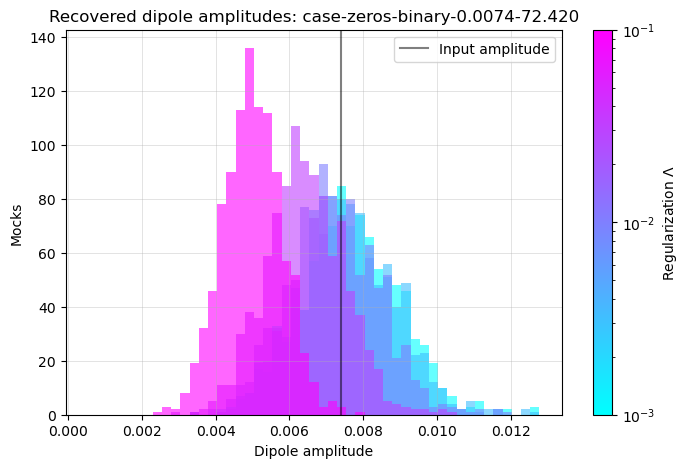

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
bins = np.linspace(np.amin(dipole_amps_mocks), np.amax(dipole_amps_mocks), 50)
for i, iLambda in enumerate(iLambdas):
    _, _, _ = ax.hist(dipole_amps_mocks[:,iLambda], bins=bins, color=smap.to_rgba(Lambdas[i]), alpha=0.6, lw=1.5, histtype='stepfilled')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(case_dict_mock['dipole_amp'], c='k', alpha=0.5, label='Input amplitude')
ax.set_xlabel('Dipole amplitude')
ax.set_ylabel('Mocks')
ax.legend()
ax.set_title('Recovered dipole amplitudes: '+case_dict_mock['tag'][1:])
fig.colorbar(smap, ax=ax, label=r'Regularization $\Lambda$')

#### direction

In [18]:
# expected/input direction
input_dir = cmb_dipole()[1]

In [19]:
# pick a Lambda
Lambda = 1e-3
iLambda_data = np.argmin(np.abs(Lambdas_data[0]-Lambda))
iLambda_mocks = np.argmin(np.abs(Lambdas_mocks[0]-Lambda))

In [20]:
# recovered dipole amplitude and direction in the data
dipole_amp_data, dipole_dir_data = get_dipole(dipole_comps_data[iLambda_data,:])

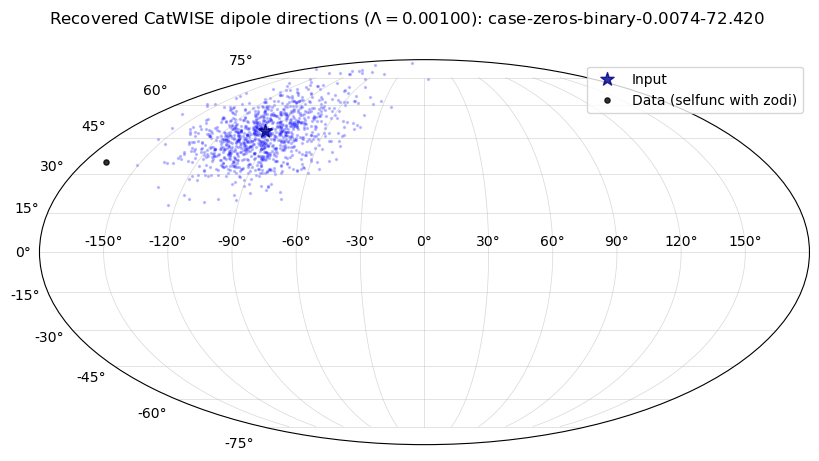

In [61]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(alpha=0.5, lw=0.5)

# recovered directions *galactic coords*
for dipdirs in dipole_dirs_mocks:
    dipdir = dipdirs[iLambda_mocks]
    theta, phi = tools.lonlat_to_thetaphi(dipdir.galactic.l, dipdir.galactic.b)
    ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.2, c='b', s=2) 

# input dipole
theta, phi = tools.lonlat_to_thetaphi(input_dir.galactic.l, input_dir.galactic.b)
ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.8, c='darkblue', marker='*', s=100, label='Input')

# data dipole
theta, phi = tools.lonlat_to_thetaphi(dipole_dir_data.galactic.l, dipole_dir_data.galactic.b)
ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.8, c='k', s=14, zorder=1000, label='Data (selfunc with zodi)')

fig.suptitle('Recovered CatWISE dipole directions ('r'$\Lambda=$'f'{Lambdas_mocks[0][iLambda]:.5f}): '+case_dict_mock['tag'][1:])
ax.legend()

In [27]:
dipole_amp_data, dipole_dir_data.galactic

(0.012321310897772301,
 <SkyCoord (Galactic): (l, b) in deg
     (191.46122008, 34.93708811)>)

In [28]:
# why is our data dipole so different from S21? regularization + selection function?

### compare data dipoles with different selection functions

In [65]:
# instantiate dipole object:
catdir = '/scratch/aew492/quasars/catalogs'
mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              #basedir=basedir,
              blim=30)
d.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, /scratch/aew492/quasars/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 4481299 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400868 sources left.


In [67]:
selfunc_dir = os.path.join(RESULTDIR, '../data/catalogs/catwise_agns/selfuncs')

#### list of selection functions

In [92]:
# 1. ecliptic latitude correction (S21)
selfunc_elatcorr = d.get_selfunc(os.path.join(selfunc_dir, 'selection_function_NSIDE64_catwise_elatcorr.fits'))
# 2. catwise "standard"
selfunc_standard = d.get_selfunc(os.path.join(selfunc_dir, 'selection_function_NSIDE64_catwise.fits'))
# 3. catwise + zodis
selfunc_zodis = d.get_selfunc(os.path.join(selfunc_dir, 'selection_function_NSIDE64_catwise_pluszodis.fits'))
# 4. catwise dust
selfunc_dust = d.get_selfunc(os.path.join(selfunc_dir, 'selection_function_NSIDE64_catwise_dust.fits'))
# 5. catwise dust + zodis
selfunc_dustzodis = d.get_selfunc(os.path.join(selfunc_dir, 'selection_function_NSIDE64_catwise_dustzodis.fits'))

selfuncs = [selfunc_elatcorr, selfunc_standard, selfunc_zodis, selfunc_dust, selfunc_dustzodis]
sf_labels = ['elatcorr', 'standard', 'pluszodis', 'dust', 'dustzodis']

elatcorr:     	0.94-1.00
standard:     	0.60-2.76
pluszodis:     	0.59-2.67
dust:     	0.64-2.03
dustzodis:     	0.66-2.05


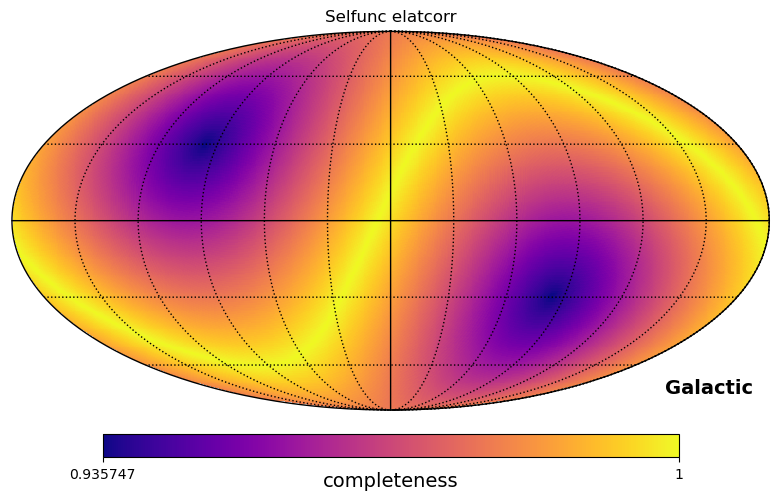

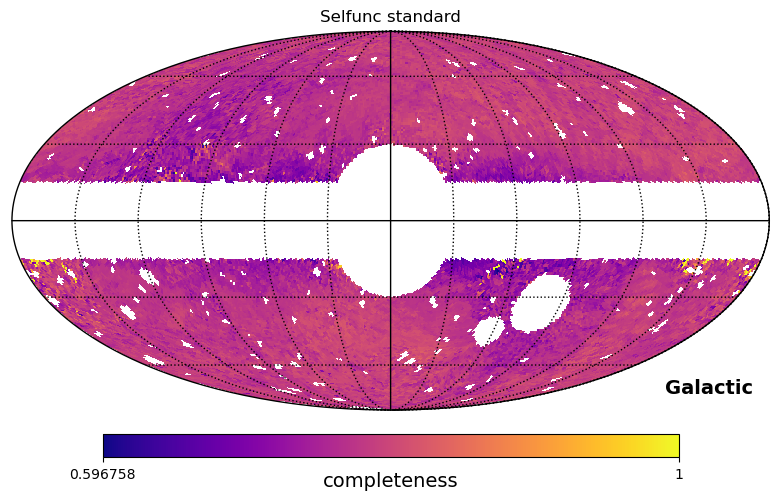

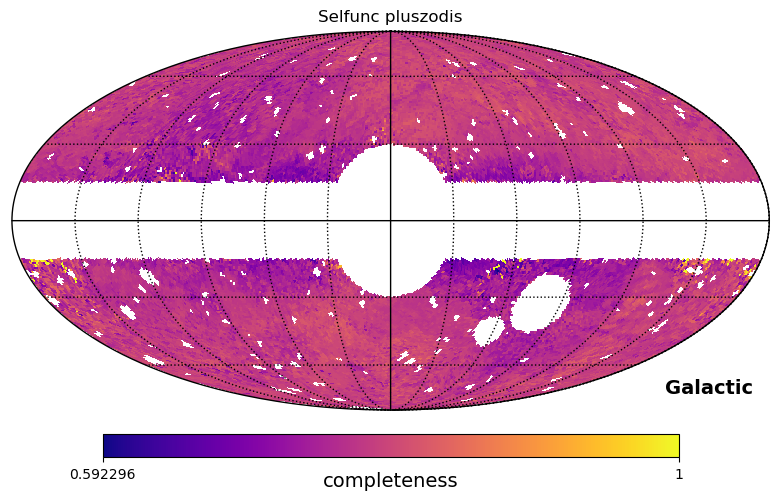

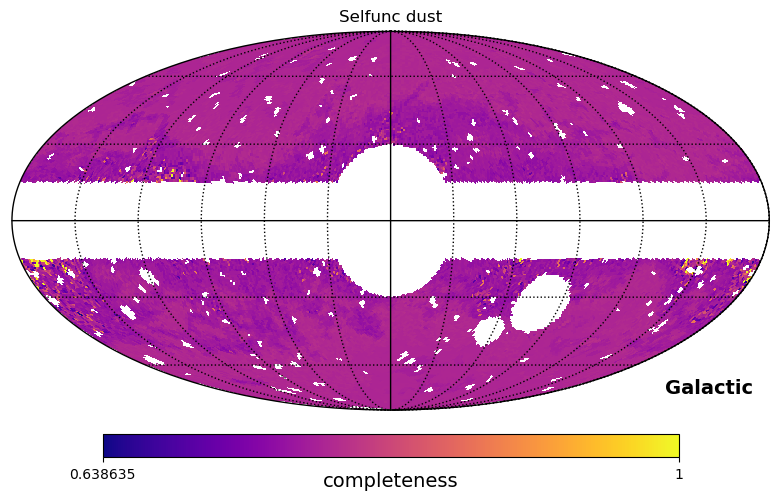

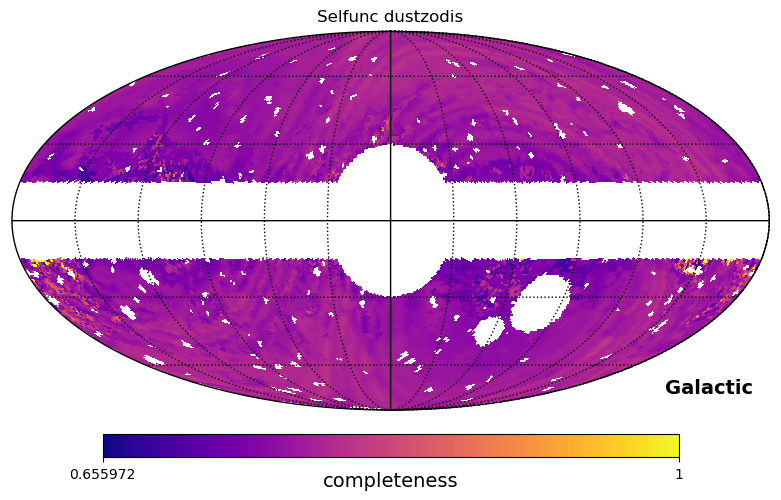

In [100]:
for i, selfunc in enumerate(selfuncs):
    fig = plt.figure(figsize=(12,5))
    selfunc_to_plot = selfunc.copy()
    selfunc_to_plot[selfunc_to_plot==0.] = np.nan
    print(f"{sf_labels[i]:}:{'':<5}\t{np.nanmin(selfunc_to_plot):.2f}-{np.nanmax(selfunc_to_plot):.2f}")
    hp.mollview(selfunc_to_plot, coord=['C','G'], title=f"Selfunc {sf_labels[i]}", unit='completeness', cmap='plasma', fig=fig, max=1., badcolor='w')
    hp.graticule()

#### measure data dipole with each selection function

In [101]:
dipole_amps = []
dipole_dirs = []
for i, selfunc in enumerate(selfuncs):
    d.set_selfunc(selfunc)
    overdensity_map = d.construct_overdensity_map()
    comps = measure_overdensity_dipole_Lambda(overdensity_map, Lambda=Lambda, selfunc=selfunc)
    damp, ddir = get_dipole(comps)
    dipole_amps.append(damp)
    dipole_dirs.append(ddir.galactic)

constructing overdensity map
constructing overdensity map
constructing overdensity map
constructing overdensity map
constructing overdensity map


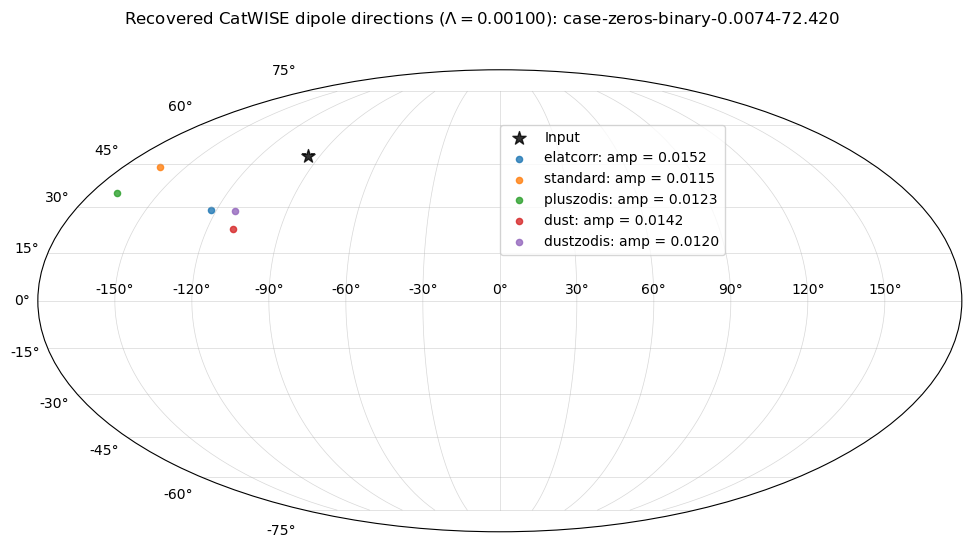

In [112]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(alpha=0.5, lw=0.5)

# input dipole
theta, phi = tools.lonlat_to_thetaphi(input_dir.galactic.l, input_dir.galactic.b)
ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.8, c='k', marker='*', s=100, label='Input')

for i, selfunc in enumerate(selfuncs):
    theta, phi = tools.lonlat_to_thetaphi(dipole_dirs[i].l, dipole_dirs[i].b)
    ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta,
               alpha=0.8, s=20, label=f"{sf_labels[i]}: amp = {dipole_amps[i]:.4f}")

fig.suptitle('Recovered CatWISE dipole directions ('r'$\Lambda=$'f'{Lambdas_mocks[0][iLambda]:.5f}): '+case_dict_mock['tag'][1:])
ax.legend(loc=(0.5,0.6))